# <center>chap9.1 Clustering</center>
---

**<font color='red' size=4>clustering</font>** is an **unsupervised** task of identifying similar instances and assigning them to **clusters**, or groups of similar instances.

It's used in a wide variety of applications:

+ <font color='blue'>customer segmentation</font>

  You can cluster customers based on their purchases and their activity on your website, so you can adapt your products and marketing campaigns to each segment. E.g., customer segmentation can be useful in **recommender systems** to suggest content that other users in the same cluster enjoyed.


+ <font color='blue'>data analysis</font>

  It's helpful to run a clustering algorithm when analyzing a new data, and then analyze each cluster separately.
  

+ <font color='blue'>nonlinear dimensionality reduction</font>

  Once a dataset has been clustered, it is usually possible to measure each instance’s **<font color='red'>affinity</font>** with each cluster (affinity is any measure of how well an instance fits into a cluster). Each instance’s feature vector $X$ can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k-dimensional. This vector is typically much lower-dimensional than the original feature vector, but it can preserve enough information for further processing.


+ <font color='blue'>anomaly detection (outlier detection)</font>

  **Any instance that has a low affinity to all the clusters is likely to be an anomaly.**
  
  **Anomaly detection is particularly useful in detecting defects in manufacturing, or for fraud detection.**


+ <font color='blue'>semi-supervised learning</font>

  **If you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster.** This can greatly increase the number of labels available for a subsequent supervised learning algorithm, and thus improve its performance.


+ <font color='blue'>search engines</font>

  **Some search engines let you search for images that are similar to a reference image.**

  To build such a system, you would first apply a clustering algorithm to all the images in your database; similar images would end up in the same cluster. Then when a user provides a reference image, all you need to do is use the trained clustering model to find this image’s cluster, and you can then simply return all the images from this cluster.


+ <font color='blue'>image segmentation</font>

  **By clustering pixels according to their color, then replacing each pixel’s color with the mean color of its cluster**, it is possible to considerably reduce the number of different colors in the image. Image segmentation is used in many object detection and tracking systems, as it makes it easier to detect the contour of each object.

<font color='crimson'>There is no universal definition (统一的定义) of what a cluster is: it really depends on the context, and different algorithms will capture different kinds of clusters.</font>

- Some algorithms look for instances centered around a particular point, called a **<font color='red'>centroid</font>**.


- Others look for continuous regions of densely packed instances: these clusters can take on any shape.


- Some algorithms are hierarchical, looking for clusters of clusters. And the list goes on.

## 1. K-Means

> It's proposed by Stuart Lloyd at Bell Labs in 1957. In 1965, Edward W. Forgy had published virtually the same algorithm. So, K-Means is sometimes referred to as Lloyd-Forgy.

In [1]:
# Common imports
import os
import sys
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
# warnings.filterwarnings(action='ignore', message="^internal gelsd")

In [2]:
print('python version:', sys.version_info)
print('matplotlib version:', mpl.__version__)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sklearn.__version__)

python version: sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib version: 3.1.2
numpy version: 1.18.1
pandas version: 1.0.1
scikit-learn version: 0.22.1


In [3]:
from sklearn.datasets import make_blobs  # blob:一点/团

In [4]:
blob_centers = np.array([
    [0.2, 2.3],
    [-1.5, 2.3],
    [-2.8, 1.8],
    [-2.8, 2.8],
    [-2.8, 1.3],
])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

In [5]:
y

array([4, 2, 0, ..., 3, 0, 2])

In [6]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14, rotation=0)

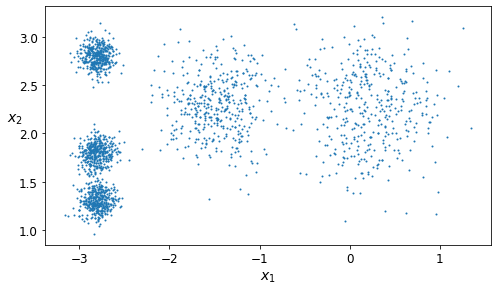

In [7]:
plt.figure(figsize=(8, 4.4))
# plot_clusters(X, y)
plot_clusters(X)
plt.show()

K-Means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in just a few iterations.

In [8]:
from sklearn.cluster import KMeans

In [9]:
k = 5
# n_init: default=10
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
# Compute cluster centers and predict cluster index for each sample.
y_pred = kmeans.fit_predict(X)
y_pred

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

**<font color='crimson'>In the context of clustering, an instance’s label is the index of the cluster that this instance gets assigned to by the algorithm.</font>**

**The `KMeans` instance preserves a copy of the labels of the instances it was trained on, available via the `labels_` instance variable:**

In [10]:
# Labels of each point
kmeans.labels_

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

**<font color='blue'>In this context, the label of an instance is the index of the cluster that instance gets assigned to.</font>**

In [11]:
y_pred is kmeans.labels_

True

In [12]:
kmeans.labels_ is y

False

In [13]:
np.array_equal(y_pred, kmeans.labels_)

True

In [14]:
y

array([4, 2, 0, ..., 3, 0, 2])

> 原始数据集的 `y` 和原始数据集的 cluster index 形式不同，但内容一样。比如，这里原始数据集中的 `y==2` 和预测结果中/`kmeans.labels_` 中的 1 代表一个意思，表示同一个 cluster。

**`kmeans.cluster_centers_`**: Coordinates of cluster centers. If the algorithm stops before fully converging (see `tol` and `max_iter`), these will not be consistent with `labels_`.

In [15]:
# Look at the 5 centroids that the algorithm found
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

In [16]:
# Assign new instances to the cluster whose centroid is closest
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

Plot the model's decision boundaries. This gives a **<font color='red'>Voronoi diagram</font>**.

In [17]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max()/10]
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=30,
                linewidths=8, color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=15,
                linewidths=50, color=cross_color, zorder=11, alpha=1)


def plot_decision_boundaries(clusterer, X, resolution=1000,
                             show_centroids=True, show_xlabels=True,
                             show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 cmap='Pastel2')
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)

    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel('$x_1$', fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel('$x_2$', fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

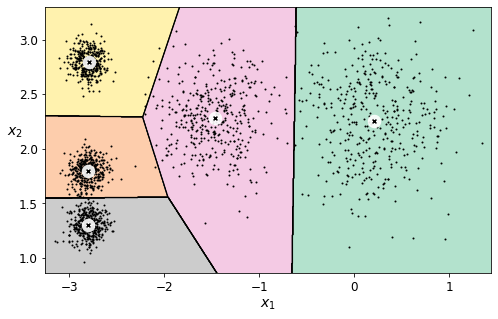

In [18]:
plt.figure(figsize=(8, 4.9))
plot_decision_boundaries(kmeans, X)
plt.show()

The vast majority of the instances were clearly assigned to the appropriate cluster, but a few instances were probably mislabeled (especially near the boundary between the top-left cluster and the central cluster).

**<font color='crimson'>Indeed, the K-Means algorithm does not behave very well when the blobs have very different diameters(直径) because all it cares about when assigning an instance to a cluster is the distance to the centroid.</font>**

## 2. Hard clustering *vs* Soft clustering

**<font color='red' size=3>hard clustering</font> assigns each instance to a single cluster**, while **<font color='red' size=3>soft clustering</font> gives each instance a score per cluster**. The score can be the distance between the instance and the centroid; conversely, it can be a similarity score (or affinity), such as the Gaussian Radial Basis Function.

**<font color='blue'>In `Kmeans` class, the `transform()` method measures the distance from each instance to every centroid.</font>**

In [19]:
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

Here, the first instance in `X_new` is located at a distance of 0.33 from the 1st centroid, 2.81 from the the 2nd centroid, 1.49 from the 3rd centroid, 2.90 from the 4th centroid, and 2.89 from the 5th centroid.

If you have a high-dimensional dataset and you transform it this way, you end up with a k-dimensional dataset: **<font color='crimson'>this transformation can be a very efficient nonlinear dimensionality reduction technique</font>**.

## 3. The K-Means algorithm (the original algorithm)

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:

- First initialize k centroids randomly: k distinct instances are chosen randomly from the dataset and the centroids are placed at their locations. 


- Repeat until convergence (i.e., until the centroids stop moving):

  - Assign each instance to the closest centroid.
  
  - Update the centroids to be the mean of the instances that are assigned to them.


**The algorithm is guaranteed to converge in a finite number of steps (usually quite small); it will not oscillate** (震荡，来回摆动) **forever.**

The `KMeans` class applies an optimized algorithm by default. **<font color='blue'>To get the original K-Means algorithm (for educational purposes only)</font>, you must set `init='random'`, `n_init=1` and `algorithm='full'`**.

Run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [20]:
kmeans_iter1 = KMeans(n_clusters=5, init='random', n_init=1, algorithm='full',
                      max_iter=1, random_state=1)  # The original K-Means algorithm
kmeans_iter2 = KMeans(n_clusters=5, init='random', n_init=2, algorithm='full',
                      max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init='random', n_init=3, algorithm='full',
                      max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=3, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

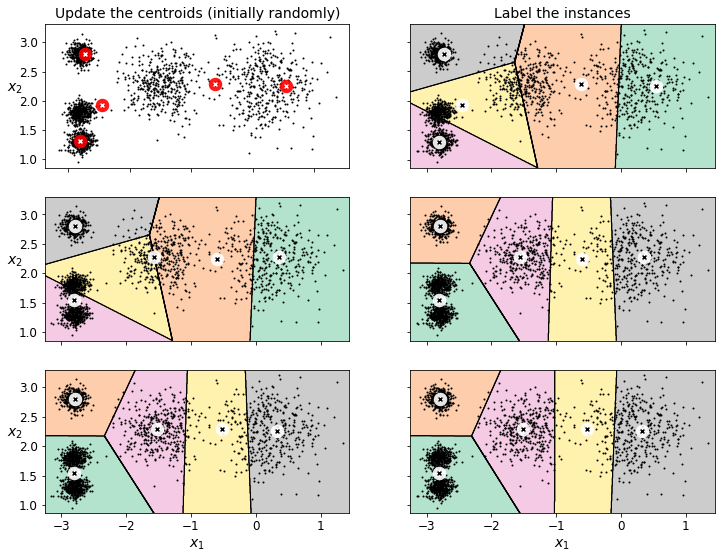

In [21]:
plt.figure(figsize=(12, 9))

# the centroids are initialized randomly
plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel('$x_2$', fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

# the instances are labeled
plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title('Label the instances', fontsize=14)

# the centroids are updated
plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

# the instances are relabeled
plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

# the centroids are updated
plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

# the instances are relabeled
plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

The centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

<div class="alert alert-block alert-info">
    <b><center>Note</center></b> <br>The <b>computational complexity of the algorithm is generally linear</b> with regard to the number of instances m, the number of clusters k, and the number of dimensions n. However, this is <b>only true when the data has a clustering structure</b>. If it does not, then in the worst-case scenario the complexity can increase exponentially with the number of instances. In practice, this rarely happens, and K-Means is generally one of the fastest clustering algorithms.
</div>

## 4. K-Means Variability

**<font color='blue'>Although the algorithm is guaranteed to converge, it may not converge to the right solution (i.e., it may converge to a local optimum): whether it does or not depends on the centroid initialization.</font>**

**If you run K-Means multiple times (or with different random seeds), it can converge to very different solutions.**

In [22]:
def plot_clusterer_comparsion(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(12, 3.6))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

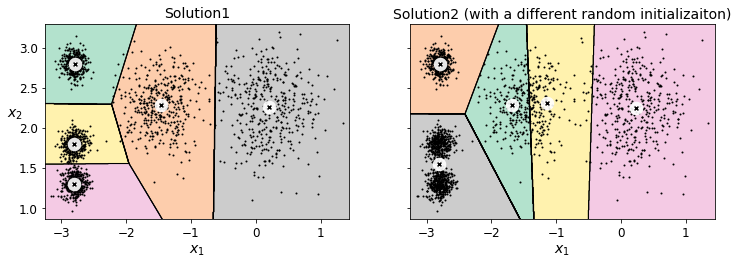

In [23]:
# The original kmeans
kmeans_rnd_init1 = KMeans(n_clusters=5, init='random', n_init=1,
                          algorithm='full', random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init='random', n_init=1,
                          algorithm='full', random_state=10)

plot_clusterer_comparsion(kmeans_rnd_init1, kmeans_rnd_init2, X, 'Solution1',
                          'Solution2 (with a different random initializaiton)')
plt.show()

Next, look at a few ways you can mitigate this risk by improving the centroid initialization.

## 5. Centroid initialization methods

**<font color='crimson'>3 ways:</font>**
+ **Way 1**: `init`=ndarray of shape (n_clusters, n_features)


+ **Way 2**: `init='random'`


+ **Way 3**: `init='k-means++`

- **<font color='green'>Way 1: know approximately where the centroids should be</font>**

If you happen to know approximately where the centroids should be, you can set the `init` hyperparameter to a NumPy array containing the list of centroids, and set `n_init` to 1.

In [27]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)

KMeans(algorithm='auto', copy_x=True,
       init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       max_iter=300, n_clusters=5, n_init=1, n_jobs=None,
       precompute_distances='auto', random_state=42, tol=0.0001, verbose=0)

- **<font color='green'>Way 2: run the algorithm multiple times with different random initializations and keep the best solution</font>**

Run the algorithm multiple times with different random initialization and keep the best one.

The number of random initialization is controlled by the **`n_init`** (default=10) hyperparameter. The algorithm runs 10 `n_init` times when you call `fit()`, and sklearn keeps the best solution.

**Model's <font color='crimson'>inertia</font> (`kmeans.inertia_`) is used as a performance metric for K-Means, which is the mean squared distance between each instance and its closest centroid.**

The `KMeans` class runs the algorithm `n_init` times and keeps the model with the lowest inertia.

In [28]:
KMeans(n_clusters=5, init='random', n_init=5, random_state=42)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=5, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [29]:
# Sum of squared distances of samples to their closest cluster center.
kmeans.inertia_

211.5985372581684

**The `score()` method returns the negative inertia.**

<div class="alert alert-block alert-danger">
    A predictor's `score()` method must always respect <b>Sklearn's "greater is better" rule</b>: if a predictor is better than another, its `score()` method should return a greater score.
</div>

In [30]:
kmeans.score(X)

-211.59853725816856

- **<font color='green'>Way 3: K-Means++</font>**

[K-Means++](https://homl.info/37) , proposed in 2006, **introduced a smarter initialization step that tends to select centroids that are distant from one another, and this improvement makes the K-Means algorithm much less likely to converge to a suboptimal solution.**

The additional computation required for the smarter initialization step is well worth it because it makes it possible to drastically reduce the number of times the algorithm needs to be run to find the optimal solution


**<font color='crimson'>K-Means++ initialization algorithm:</font>**

1. Take one centroid $c^1$, chosen uniformly at random from the dataset

2. Take a new centroid $c^i$, choosing an instance $x^i$ with probability ${D(x^i)}^2 / \sum^m_{j=1}{D(x^j)}^2$, where ${D(x^i)}$ is the distance between the instance $x^i$ and the closest centroid that was already chosen. This probability distribution ensures that instances farther away from already chosen centroids are much more likely be selected as centroids.

3. Repeat the previous step until all k centroids have been chosen.


**This initialization method is default in `Kmeans` class.**

In [31]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## 6. Accelerate K-Means

- **<font color='green'>Way 1:</font>**

[2003 paper by Charles Elkan](https://homl.info/38) considerably **accelerates the algorithm by avoiding many unnecessary distance calculation**. Elkan achieved this by **exploiting** (利用) **the triangle inequality (i.e., that a straight line is always the shortest distance between two points) and by keeping track of lower and upper bounds for distances between instances and centroids**.

**To use Elkan variant of K-Means, just set `algorithm='elkan'`.** It **does not support sparse data**. So by default, Sklearn uses `'elkan'` for dense data, and `'full'` (the regular K-Means algorithm) fro sparse data. 

In [32]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [34]:
# Elkan variant for K-Means
%timeit -n 50 KMeans(algorithm='elkan', random_state=42).fit(X)

54.4 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [35]:
# The regular K-Means
%timeit -n 50 KMeans(algorithm='full', random_state=42).fit(X)

79 ms ± 5.33 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


- **<font color='green'>Way 2:</font>**

In [2010 paper by David Sculley](https://homl.info/39), instead of using the full dataset at each iteration, the algorithm is capable of **using mini-batches, moving the centroids just slightly at each iteration**.

**This speeds up the algorithm typically by a factor of three or four and makes it possible to cluster huge datasets that do not fit in memory.**

In [36]:
from sklearn.cluster import MiniBatchKMeans

In [37]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [38]:
minibatch_kmeans.inertia_

211.93186531476775

1. **<font color='crimson'>If the dataset does not fit in memory, the simplest option is to use the memmap class</font>** (as we did for incremental PCA in Chapter 8.) 


2. **Alternatively**, you can **pass one mini-batch at a time to the `partial_fit()` method**, but this will require much more work, since you will need to perform multiple initializations and select the best one yourself (see the mini-batch K-Means section of the notebook for an example).

In [39]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

x_train, x_test, y_train, y_test = train_test_split(
    mnist['data'], mnist['target'], random_state=42)
x_train.shape, x_test.shape

((52500, 784), (17500, 784))

In [40]:
# Use `np.memmap()` if the dataset does not fit in memory
filename = '../datasets/my_mnist_chap9.data'
x_mm = np.memmap(filename, dtype='float32', mode='write', shape=x_train.shape)
x_mm[:] = x_train

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(x_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

**If your data is so large that you cannot use `memmap`, things get more complicated.** Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [42]:
def load_next_batch(batch_size, data=X):
    return data[np.random.choice(len(data), batch_size, replace=False)]

In [43]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size,
                                       random_state=42)
    x_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(x_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        x_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(x_batch)
        if iteration >= n_iterations-evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [44]:
best_kmeans.score(X)

-211.69840901859536

In [45]:
best_kmeans.inertia_  # 🤔

12.017759887238839

In [46]:
best_kmeans.sum_inertia_  # 🤔

101.5380140190461

**Mini-batch K-Means is much faster than regular K-Means:**

In [47]:
# regular K-Means
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

29.3 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
# Mini-batch K-Means
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

16.4 ms ± 895 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**<font color='crimson'>Although the Mini-batch K-Means algorithm is much faster than the regular K-Means algorithm, its inertia is generally slightly worse, especially as the number of clusters increases.</font>**

In [49]:
from timeit import timeit

In [50]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))

for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

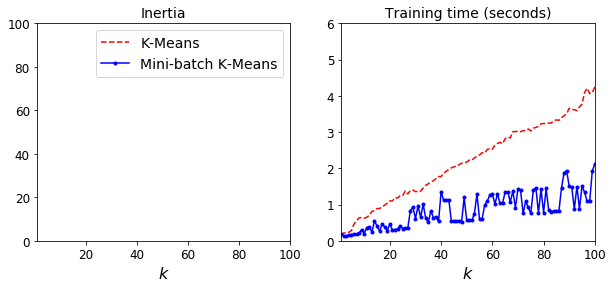

In [51]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], 'r--', label='K-Means')
plt.plot(range(1, 101), inertias[:, 1], 'b.-', label='Mini-batch K-Means')
plt.xlabel('$k$', fontsize=16)
plt.title('Inertia', fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label='K-Means')
plt.plot(range(1, 101), times[:, 1], "b.-", label='Mini-batch K-Means')
plt.xlabel('$k$', fontsize=16)
plt.title('Training time (seconds)', fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

> + (left plot) The difference between the two curves remains fairly constant, but this difference becomes more and more significant as k increases, since the inertia becomes smaller and smaller.
> + (right plot) Mini-batch K-Means is much faster than regular K-Means, and this difference increases with k.

## 7. Find the optimal number of clusters